# Sélection du degré du polynôme du chaos dans le modèle d'Ishigami

In [1]:
import openturns as ot
import openturns.viewer as otv
import pylab as pl
import numpy as np

In [2]:
from openturns.usecases import ishigami_function as ishigami_function

In [3]:
im = ishigami_function.IshigamiModel()

In [4]:
im.distributionX

class=ComposedDistribution name=ComposedDistribution dimension=3 copula=class=IndependentCopula name=IndependentCopula dimension=3 marginal[0]=class=Uniform name=X1 dimension=1 a=-3.14159 b=3.14159 marginal[1]=class=Uniform name=X2 dimension=1 a=-3.14159 b=3.14159 marginal[2]=class=Uniform name=X1 dimension=1 a=-3.14159 b=3.14159

In [5]:
im.model

class=FunctionImplementation name=Unnamed description=[X1,X2,X3,y0] evaluationImplementation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[X1,X2,X3,a,b,y0] evaluationImplementation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[X1,X2,X3,a,b] outputVariablesNames=[y0] formulas=[sin(X1) + a * sin(X2)^2 + b * X3^4 * sin(X1)] gradientImplementation=class=SymbolicGradient name=Unnamed evaluation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[X1,X2,X3,a,b] outputVariablesNames=[y0] formulas=[sin(X1) + a * sin(X2)^2 + b * X3^4 * sin(X1)] hessianImplementation=class=SymbolicHessian name=Unnamed evaluation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[X1,X2,X3,a,b] outputVariablesNames=[y0] formulas=[sin(X1) + a * sin(X2)^2 + b * X3^4 * sin(X1)] parameters positions=[3,4] parameters=class=PointWithDescription name=Unnamed dimension=2 description=[a,b] values=[7,0.1] input positions=[0,1,2] gradientImplementation=class=ParametricGradient evaluation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[X1,X2,X3,a,b,y0] evaluationImplementation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[X1,X2,X3,a,b] outputVariablesNames=[y0] formulas=[sin(X1) + a * sin(X2)^2 + b * X3^4 * sin(X1)] gradientImplementation=class=SymbolicGradient name=Unnamed evaluation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[X1,X2,X3,a,b] outputVariablesNames=[y0] formulas=[sin(X1) + a * sin(X2)^2 + b * X3^4 * sin(X1)] hessianImplementation=class=SymbolicHessian name=Unnamed evaluation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[X1,X2,X3,a,b] outputVariablesNames=[y0] formulas=[sin(X1) + a * sin(X2)^2 + b * X3^4 * sin(X1)] parameters positions=[3,4] parameters=class=PointWithDescription name=Unnamed dimension=2 description=[a,b] values=[7,0.1] input positions=[0,1,2] hessianImplementation=class=ParametricHessian evaluation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[X1,X2,X3,a,b,y0] evaluationImplementation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[X1,X2,X3,a,b] outputVariablesNames=[y0] formulas=[sin(X1) + a * sin(X2)^2 + b * X3^4 * sin(X1)] gradientImplementation=class=SymbolicGradient name=Unnamed evaluation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[X1,X2,X3,a,b] outputVariablesNames=[y0] formulas=[sin(X1) + a * sin(X2)^2 + b * X3^4 * sin(X1)] hessianImplementation=class=SymbolicHessian name=Unnamed evaluation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[X1,X2,X3,a,b] outputVariablesNames=[y0] formulas=[sin(X1) + a * sin(X2)^2 + b * X3^4 * sin(X1)] parameters positions=[3,4] parameters=class=PointWithDescription name=Unnamed dimension=2 description=[a,b] values=[7,0.1] input positions=[0,1,2]

In [6]:
def ComputeSparseLeastSquaresChaos(
    inputTrain, outputTrain, multivariateBasis, totalDegree, myDistribution
):
    """
    Create a sparse polynomial chaos with least squares.

    * Uses the enumeration rule from multivariateBasis.
    * Uses LeastSquaresStrategy to compute the coefficients from
    linear least squares.
    * Uses LeastSquaresMetaModelSelectionFactory to select the polynomials
    in the basis using least angle regression stepwise (LARS)
    * Uses LeastSquaresStrategy to compute the coefficient using 
    least squares.
    * Uses FixedStrategy to keep all coefficients that LARS has selected,
    up to the given maximum total degree.

    Parameters
    ----------
    inputTrain : ot.Sample(n)
        The input training design of experiments with n points
    outputTrain : ot.Sample(n)
        The input training design of experiments with n points
    multivariateBasis : ot.Basis
        The multivariate orthogonal polynomial basis
    totalDegree : int
        The maximum total polynomial degree
    myDistribution : ot.Distribution
        The distribution of the input random vector

    Returns
    -------
    result : ot.FunctionalChaosResult
        The polynomial chaos result
    """
    selectionAlgorithm = ot.LeastSquaresMetaModelSelectionFactory()
    projectionStrategy = ot.LeastSquaresStrategy(
        inputTrain, outputTrain, selectionAlgorithm
    )
    enumfunc = multivariateBasis.getEnumerateFunction()
    P = enumfunc.getStrataCumulatedCardinal(totalDegree)
    adaptiveStrategy = ot.FixedStrategy(multivariateBasis, P)
    chaosalgo = ot.FunctionalChaosAlgorithm(
        inputTrain, outputTrain, myDistribution, adaptiveStrategy, projectionStrategy
    )
    chaosalgo.run()
    result = chaosalgo.getResult()
    return result

In [7]:
dimension = im.distributionX.getDimension()

In [8]:
multivariateBasis = ot.OrthogonalProductPolynomialFactory(
    [im.distributionX.getMarginal(i) for i in range(dimension)]
)

Generate an training sample of size N with MC simulation (or retrieve the design from experimental data).

In [9]:
training_sample_size = 200  # Size of the training design of experiments

inputTrain = im.distributionX.getSample(training_sample_size)
outputTrain = im.model(inputTrain)

In [10]:
totalDegree = 2  # Polynomial degree
result = ComputeSparseLeastSquaresChaos(
    inputTrain, outputTrain, multivariateBasis, totalDegree, im.distributionX
)

La méthode `getMetaModel` retourne une fonction permettant d'évaluer le métamodèle.

In [11]:
metamodel = result.getMetaModel()
type(metamodel)

openturns.func.Function

## Validate the metamodel

Generate a validation sample (which is independent of the training sample).

In [12]:
test_sample_size = 200  # Size of the validation design of experiments
inputTest = im.distributionX.getSample(test_sample_size)
outputTest = im.model(inputTest)

La classe `MetaModelValidation` permet de valider le métamodèle sur une base de validation.

In [13]:
validation = ot.MetaModelValidation(inputTest, outputTest, metamodel)

Compute the $Q^2$ predictability coefficient

In [14]:
Q2 = validation.computePredictivityFactor()[0]
Q2

0.2009142524137396

Le métamodèle est ici d'excellente qualité, puisque le $Q^2$ est supérieur à 99%. Cela signifie que moins de 1% de la variance de la sortie est perdue en substituant le métamodèle au modèle. 

Plot the observed versus the predicted outputs.

/home/devel/miniconda3/envs/otsupgalilee/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/devel/miniconda3/envs/otsupgalilee/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


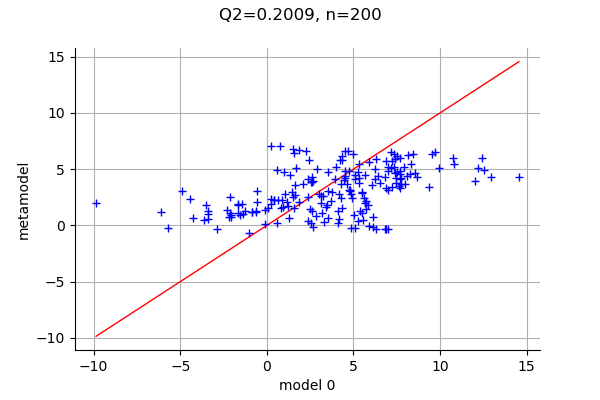

In [15]:
graph = validation.drawValidation()
graph.setTitle("Q2=%.4f, n=%d" % (Q2, test_sample_size))
graph

La fonction suivante calcule et affiche le Q2 et produit le diagramme de validation.

In [16]:
def printQ2Chaos(multivariateBasis, chaosResult, inputTest, outputTest, totalDegree):
    sparsityRate = computeSparsityRate(multivariateBasis, totalDegree, chaosResult)
    metamodel = chaosResult.getMetaModel()  # get the metamodel
    val = ot.MetaModelValidation(inputTest, outputTest, metamodel)
    Q2 = val.computePredictivityFactor()[0]
    Q2 = max(Q2, 0.0)
    grid = val.drawValidation()
    graph = grid.getGraph(0, 0)
    legend1 = "D=%d, Q2=%.0f%%" % (totalDegree, 100 * Q2)
    graph.setLegends(["", legend1])
    graph.setLegendPosition("topleft")
    grid.setGraph(0, 0, graph)
    print(
        "Degree=%d, Q2=%.2f%%, Sparsity=%.2f%%"
        % (totalDegree, 100 * Q2, 100 * sparsityRate)
    )
    return graph

In [17]:
def computeSparsityRate(multivariateBasis, totalDegree, chaosResult):
    """Compute the sparsity rate, assuming a FixedStrategy."""
    # Get P, the maximum possible number of coefficients
    enumfunc = multivariateBasis.getEnumerateFunction()
    P = enumfunc.getStrataCumulatedCardinal(totalDegree)
    # Get number of coefficients in the selection
    indices = chaosResult.getIndices()
    nbcoeffs = indices.getSize()
    # Compute rate
    sparsityRate = nbcoeffs / P
    return sparsityRate

In [18]:
def computeQ2Chaos(chaosResult, inputTest, outputTest):
    """Compute the Q2 of a chaos"""
    metamodel = chaosResult.getMetaModel()
    val = ot.MetaModelValidation(inputTest, outputTest, metamodel)
    Q2 = val.computePredictivityFactor()[0]
    Q2 = max(Q2, 0.0)
    return Q2

Degree=1, Q2=17.68%, Sparsity=50.00%
Degree=2, Q2=20.09%, Sparsity=30.00%
Degree=3, Q2=54.37%, Sparsity=25.00%
Degree=4, Q2=77.55%, Sparsity=17.14%
Degree=5, Q2=86.76%, Sparsity=16.07%


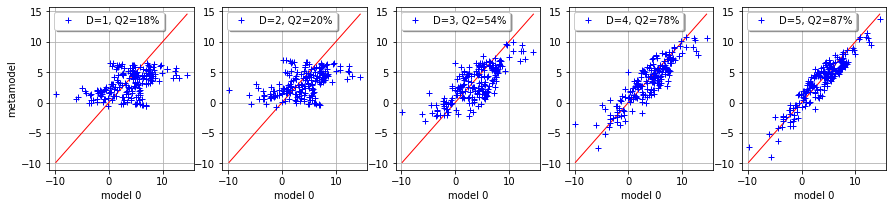

In [19]:
ot.RandomGenerator.SetSeed(0)
maxDegree = 6
inputTrain = im.distributionX.getSample(training_sample_size)
outputTrain = im.model(inputTrain)
inputTest = im.distributionX.getSample(test_sample_size)
outputTest = im.model(inputTest)
fig = pl.figure(figsize=(15.0, 3.0))
for totalDegree in range(1, maxDegree):
    chaosResult = ComputeSparseLeastSquaresChaos(
        inputTrain, outputTrain, multivariateBasis, totalDegree, im.distributionX
    )
    graph = printQ2Chaos(
        multivariateBasis, chaosResult, inputTest, outputTest, totalDegree
    )
    if totalDegree > 1:
        graph.setYTitle("")
    ax = fig.add_subplot(1, maxDegree - 1, totalDegree)
    _ = ot.viewer.View(graph, figure=fig, axes=[ax])

Répétons l'expérience pour observer la variabilité du Q2.

In [20]:
def computeSampleQ2(
    training_sample_size,
    test_sample_size,
    numberAttempts,
    maxDegree,
    input_distribution,
    model,
):
    """
    Compute repetitions of the predictability coefficient for different polynomial degrees.

    For a given sample size equal to training_sample_size,
    for degree from 1 to maxDegree,
    repeat the following experiment numberAttempts times:

    * create a sparse least squares chaos
    * compute the Q2 using a sample size equal to test_sample_size

    Parameters
    ----------
    training_sample_size : int
        The size of the training sample.
    test_sample_size : int
        The size of the test sample
    numberAttempts : int
        The number of repetitions.
    maxDegree : int
        The maximum polynomial degree.
    input_distribution : ot.Distribution
        The input distribution of the model.
    model : ot.Function
        The function.

    Returns
    -------
    Q2sample : ot.Sample(numberAttempts, maxDegree)
        The value of the predictability coefficient for each repetition, for each degree.
    """
    Q2sample = ot.Sample(numberAttempts, maxDegree)
    for totalDegree in range(1, maxDegree + 1):
        print("Degree = %d" % (totalDegree))
        for i in range(numberAttempts):
            inputTrain = input_distribution.getSample(training_sample_size)
            outputTrain = model(inputTrain)
            inputTest = input_distribution.getSample(test_sample_size)
            outputTest = model(inputTest)
            chaosResult = ComputeSparseLeastSquaresChaos(
                inputTrain,
                outputTrain,
                multivariateBasis,
                totalDegree,
                input_distribution,
            )
            Q2sample[i, totalDegree - 1] = computeQ2Chaos(
                chaosResult, inputTest, outputTest
            )
    return Q2sample

In [21]:
def plotQ2Boxplots(Q2sample, training_sample_size):
    """
    Plot the Q2 as a boxplot.

    Parameters
    ----------
    Q2sample : ot.Sample(numberAttempts, maxDegree)
        The value of the predictability coefficient for each repetition, for each degree.
    training_sample_size : int
        The size of the training sample.

    Returns
    -------
    figure : pl.boxplot
        The boxplot showing the Q2 depending on the polynomial degree.
    """
    data = np.array(Q2sample)
    fig = pl.figure()
    pl.boxplot(data)
    pl.xlabel("Degree")
    pl.ylabel("Q2 (%)")
    return fig

Degree = 1
Degree = 2
Degree = 3
Degree = 4
Degree = 5
Degree = 6
Degree = 7
Degree = 8


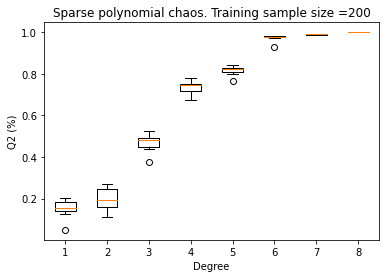

In [22]:
training_sample_size = 200  # Size of the training design of experiments
test_sample_size = 200
numberAttempts = 4  # 10  for real simulations
maxDegree = 4  # 8 for real simulations
Q2sample = computeSampleQ2(
    training_sample_size,
    test_sample_size,
    numberAttempts,
    maxDegree,
    im.distributionX,
    im.model,
)
_ = plotQ2Boxplots(Q2sample, training_sample_size)

pl.title("Sparse polynomial chaos. Training sample size =%d" % (training_sample_size))
_.savefig("chaos-ishigami-N%d-various-degrees.pdf" % (training_sample_size))